In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv(r'G:\traindata\RFMtest\Retail_Data_Transactions.csv')
df.head()

,customer_id,trans_date,tran_amount
0,CS5295,11-Feb-13,35
1,CS4768,15-Mar-15,39
2,CS2122,26-Feb-13,52
3,CS1217,16-Nov-11,99
4,CS1850,20-Nov-13,78


In [3]:
df['trans_date'] = pd.to_datetime(df['trans_date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125000 entries, 0 to 124999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   customer_id  125000 non-null  object        
 1   trans_date   125000 non-null  datetime64[ns]
 2   tran_amount  125000 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.9+ MB


In [4]:
df['trans_date'].min()

Timestamp('2011-05-16 00:00:00')

In [7]:
R_today = dt.datetime(2015,3,17)

In [9]:
df['R_diff'] = (R_today-df['trans_date']).dt.days
df.head()

,customer_id,trans_date,tran_amount,R_diff
0,CS5295,2013-02-11,35,764
1,CS4768,2015-03-15,39,2
2,CS2122,2013-02-26,52,749
3,CS1217,2011-11-16,99,1217
4,CS1850,2013-11-20,78,482


In [10]:
R = df.groupby(by = ['customer_id'])['R_diff']
R.head()

0          764
1            2
2          749
3         1217
4          482
          ... 
124305     876
124326     793
124395      66
124602     252
124878     992
Name: R_diff, Length: 34439, dtype: int64

In [11]:
R = R.agg([('R_diff','min')])
R.head()

,R_diff
customer_id,
CS1112,62
CS1113,36
CS1114,33
CS1115,12
CS1116,204


In [12]:
F = df.groupby(by = ['customer_id'])['customer_id'].agg([('F_fre','count')])
M = df.groupby(by = ['customer_id'])['tran_amount'].agg([('M_sum',sum)])
RFM = R.join(F).join(M)
RFM.head()

,R_diff,F_fre,M_sum
customer_id,,,
CS1112,62,15,1012
CS1113,36,20,1490
CS1114,33,19,1432
CS1115,12,22,1659
CS1116,204,13,857


In [13]:
RFM.describe()

,R_diff,F_fre,M_sum
count,6889.000000,6889.000000,6889.000000
mean,81.538249,18.144869,1179.269705
std,85.382526,5.193014,465.832609
min,1.000000,4.000000,149.000000
25%,23.000000,14.000000,781.000000
50%,54.000000,18.000000,1227.000000
75%,112.000000,22.000000,1520.000000
max,858.000000,39.000000,2933.000000


In [19]:
bins = RFM['R_diff'].quantile(q = np.linspace(0,1,6),interpolation = 'nearest')
bins[0] = 0
labels =  [5,4,3,2,1]
R1 = pd.cut(RFM['R_diff'],bins,labels = labels)

bins = RFM['F_fre'].quantile(q = np.linspace(0,1,6),interpolation = 'nearest')
bins[0] = 0
labels = [1,2,3,4,5]
F1 = pd.cut(RFM['F_fre'],bins,labels = labels)

bins = RFM['M_sum'].quantile(q = np.linspace(0,1,6),interpolation = 'nearest')
bins[0] = 0
labels = [1,2,3,4,5]
M1 = pd.cut(RFM['M_sum'],bins,labels = labels)

RFM['R1'] = R1
RFM['F1'] = F1
RFM['M1'] = M1
RFM.head()

,R_diff,F_fre,M_sum,R1,F1,M1
customer_id,,,,,,
CS1112,62,15,1012,3,2,2
CS1113,36,20,1490,4,3,4
CS1114,33,19,1432,4,3,4
CS1115,12,22,1659,5,4,5
CS1116,204,13,857,1,1,2


In [20]:
RFM['RFM'] = 0.2*R1.astype(int)+0.3*F1.astype(int)+0.5*M1.astype(int)
RFM.head()

,R_diff,F_fre,M_sum,R1,F1,M1,RFM
customer_id,,,,,,,
CS1112,62,15,1012,3,2,2,2.2
CS1113,36,20,1490,4,3,4,3.7
CS1114,33,19,1432,4,3,4,3.7
CS1115,12,22,1659,5,4,5,4.7
CS1116,204,13,857,1,1,2,1.5


In [21]:
bins = RFM['RFM'].quantile(q = [0,0.125,0.25,0.375,0.5,0.625,0.75,0.875,1],interpolation='nearest')
bins[0] =0
labels =  ['流失客户','一般维持客户','一般发展客户','潜力客户','重要挽留客户','重要保持客户','重要发展客户','重要价值客户']
RFM['types'] = pd.cut(RFM.RFM,bins,labels=labels)
RFM.head() 

,R_diff,F_fre,M_sum,R1,F1,M1,RFM,types
customer_id,,,,,,,,
CS1112,62,15,1012,3,2,2,2.2,一般发展客户
CS1113,36,20,1490,4,3,4,3.7,重要保持客户
CS1114,33,19,1432,4,3,4,3.7,重要保持客户
CS1115,12,22,1659,5,4,5,4.7,重要价值客户
CS1116,204,13,857,1,1,2,1.5,一般维持客户


In [22]:
Money = RFM.groupby(by = ['types'])['M_sum'].agg([('money_diff',sum)])
Money.head(9)

,money_diff
types,
流失客户,445846
一般维持客户,565699
一般发展客户,818815
潜力客户,1050493
重要挽留客户,1151775
重要保持客户,1105953
重要发展客户,1436480
重要价值客户,1548928


In [23]:
person = RFM.groupby(by = ['types'])['types'].agg([('types','count')])
person.head(9)

,types
types,
流失客户,911
一般维持客户,812
一般发展客户,882
潜力客户,931
重要挽留客户,882
重要保持客户,757
重要发展客户,872
重要价值客户,842


In [26]:
df1 = RFM.reset_index()
df1

,customer_id,R_diff,F_fre,M_sum,R1,F1,M1,RFM,types
0,CS1112,62,15,1012,3,2,2,2.2,一般发展客户
1,CS1113,36,20,1490,4,3,4,3.7,重要保持客户
2,CS1114,33,19,1432,4,3,4,3.7,重要保持客户
3,CS1115,12,22,1659,5,4,5,4.7,重要价值客户
4,CS1116,204,13,857,1,1,2,1.5,一般维持客户
...,...,...,...,...,...,...,...,...,...
6884,CS8996,98,13,582,2,1,1,1.2,流失客户
6885,CS8997,262,14,543,1,1,1,1.0,流失客户
6886,CS8998,85,13,624,2,1,1,1.2,流失客户
6887,CS8999,258,12,383,1,1,1,1.0,流失客户


In [27]:
df1 = df1.pivot_table('customer_id',index = 'types',aggfunc='count')
df1 = df1.rename(columns = {'customer_id':'numbers'}).reset_index()
df1

,types,numbers
0,流失客户,911
1,一般维持客户,812
2,一般发展客户,882
3,潜力客户,931
4,重要挽留客户,882
5,重要保持客户,757
6,重要发展客户,872
7,重要价值客户,842


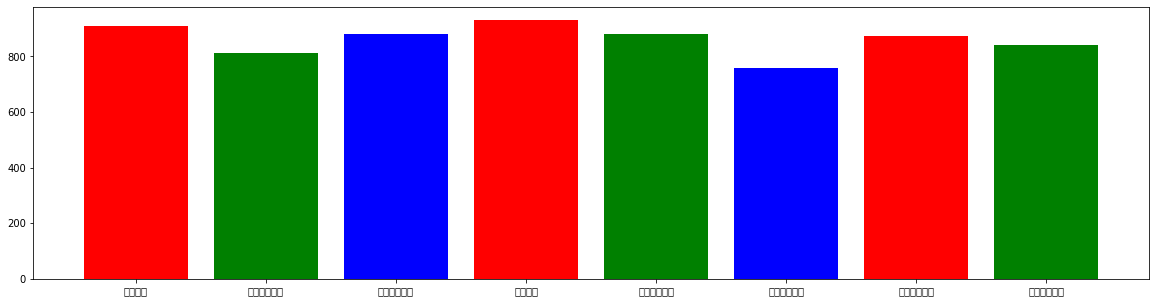

In [35]:
plt.figure(figsize=(20,5))
plt.bar(data=df1,x = 'types',height = 'numbers',color = 'rgb')
plt.show()